<a href="https://colab.research.google.com/github/nomomon/NLP-course-project/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os 
import re 

from tqdm import tqdm

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Load the dataset

In [3]:
en_url = "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/train.en"
de_url = "https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/train.de"

en_file = tf.keras.utils.get_file("train.en", en_url)
de_file = tf.keras.utils.get_file("train.de", de_url)

# en_file = '/Users/mansurnurmukhambetov/.keras/datasets/train.en'
# de_file = '/Users/mansurnurmukhambetov/.keras/datasets/train.de'

In [4]:
file = open(de_file, 'r')
len(file.readlines())

4468840

In [5]:
file = open(en_file, 'r')
len(file.readlines())

4468840

## Preprocessing

In [7]:
def make_dataset(file_path):
    # read file
    with open(file_path, "r") as f:
        lines = f.read().splitlines()

    # create DataFrame
    dataset = pd.DataFrame({"sentence": lines[:100]})

    # remove non-alphanumeric, punctuation and german ulmauts
    dataset = dataset.applymap(
        lambda string: re.sub("\s+", " ", 
                              re.sub(r"[^A-Za-z0-9äöüÄÖÜß]", " ", string)
        )
    ) # (),!?\'\`

    # convert text to lowercase
    dataset =  dataset.applymap(lambda string: string.lower())

    return dataset

en_dataset = make_dataset(en_file)
de_dataset = make_dataset(de_file)

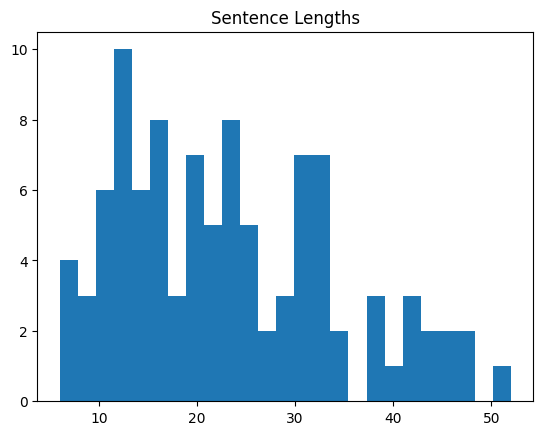

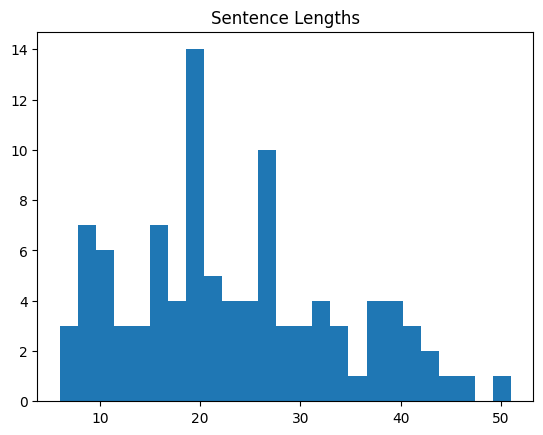

In [174]:
# visualize sentence lengths

def visualize_sentence_lengths(dataset):
    lengths = dataset.sentence.str.split().str.len()

    plt.title("Sentence Lengths")
    plt.hist(lengths, bins=25)
    plt.show()
    return lengths

en_lengths = visualize_sentence_lengths(en_dataset)
de_lengths = visualize_sentence_lengths(de_dataset);

In [175]:
en_length = 30
de_length = 30

## Tokenization

In [238]:
class Tokenizer():
    def __init__(self, num_words, filters, oov_token):
        self.num_words = num_words
        self.filters = filters
        self.oov_token = oov_token
        self.vocab = {}
        self.inv_vocab = {}


    # def split(self, text):
    #     return re.findall(r"\w+|[^\w\s]", text, re.UNICODE)

    def fit_on_texts(self, corpus):
        x = corpus.astype('U')
        x = np.char.split(x)
        x = np.concatenate(x).ravel()
        u, c = np.unique(x, return_counts=True)
        count_sort_ind = np.argsort(-c)
        u = u[count_sort_ind][:self.num_words + 1]
        i = np.arange(1, len(u))

        self.vocab = dict(zip(u, i))
        self.vocab[self.oov_token] = 0

        self.inv_vocab = dict(zip(i, u))
        self.inv_vocab[0] = self.oov_token

    def t2i(self, token):
        if token in self.vocab:
            return self.vocab[token]
        else: 
            return 0

    def i2t(self, idx):
        if idx in self.inv_vocab:
            return self.inv_vocab[idx]
        else: 
            return self.inv_vocab[0]

    def text_to_sequence(self, text):
        x = text.split()
        x = [self.t2i(token) for token in x]
        x = np.array(x)
        return x

    def sequence_to_text(self, seq):
        x = [self.i2t(idx) for idx in seq]
        x = " ".join(x)
        return x

In [239]:
# function to build a tokenizer
def build_tokenizer(dataset, vocab_size=None):
    tokenizer = Tokenizer(num_words=vocab_size, filters="", oov_token="<unk>")
    tokenizer.fit_on_texts(dataset.sentence.values.flatten())

    return tokenizer

In [240]:
# prepare english tokenizer
eng_tokenizer = build_tokenizer(en_dataset, 1000)
eng_vocab_size = eng_tokenizer.num_words + 1

print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 1001


In [241]:
# prepare german tokenizer
ger_tokenizer = build_tokenizer(de_dataset, 1000)
ger_vocab_size = ger_tokenizer.num_words + 1

print('German Vocabulary Size: %d' % ger_vocab_size)

German Vocabulary Size: 1001


In [180]:
# split data into train and test set
(
    en_dataset_train, 
    en_dataset_test, 
    de_dataset_train, 
    de_dataset_test
 ) = train_test_split(en_dataset, de_dataset, test_size=0.2, random_state = 12)

In [181]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = [tokenizer.text_to_sequence(text) for text in lines]
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [182]:
# prepare training data
trainX = encode_sequences(eng_tokenizer, en_length, en_dataset_train.values.flatten())
trainY = encode_sequences(ger_tokenizer, de_length, de_dataset_train.values.flatten())

# # prepare validation data
testX = encode_sequences(eng_tokenizer, en_length, en_dataset_test.values.flatten())
testY = encode_sequences(ger_tokenizer, de_length, de_dataset_test.values.flatten())

## Model

In [183]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import optimizers

In [184]:
def define_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    # model = Sequential()
    # # encoder
    # model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    # model.add(LSTM(units, return_sequences=True))
    # # decoder
    # model.add(LSTM(units))
    # model.add(Dense(units, activation='relu'))
    # model.add(Dense(out_vocab, activation='softmax'))

    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))

    opt = optimizers.Adam(lr=0.001)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy')

    return model

model = define_model(eng_vocab_size, ger_vocab_size, en_length, de_length, 10)

In [185]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 10)            10010     
                                                                 
 lstm_4 (LSTM)               (None, 10)                840       
                                                                 
 repeat_vector_2 (RepeatVect  (None, 30, 10)           0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 30, 10)            840       
                                                                 
 dense_2 (Dense)             (None, 30, 1001)          11011     
                                                                 
Total params: 22,701
Trainable params: 22,701
Non-trainable params: 0
__________________________________________________

In [ ]:
# train model
history = model.fit(trainX, trainY[:, :, None],
                    epochs=300, batch_size=32, validation_split=0.2, verbose=1)

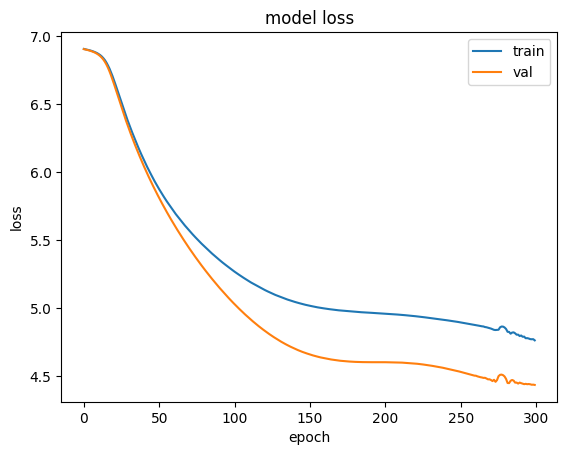

In [188]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [247]:
text = 'please read the instructions' #@param {type:"string"}


def translate_en_ge(text):
    seq = encode_sequences(eng_tokenizer, en_length, [text])
    probs = model.predict(seq)[0] # (30, 1001)
    probs[:, 0] = 0               # not use 0
    probs = probs / probs.sum(axis=1, keepdims=True)

    ind = [
        np.random.choice(eng_tokenizer.num_words+1, p=prob)
        for prob in probs
    ]
    

    sentence = ger_tokenizer.sequence_to_text(ind)

    return sentence

translation = translate_en_ge(text)

1/1 [==============================] - 0s 44ms/step


In [248]:
translation

'kostenfreien xfl websites surveillance klar second every formecken paste weltweit psd downloading 8 vereinbaren sollten ever time tools freehand vergleichsseiten oder at at at datei und at kanzlei view wachstum'